# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Libraries

In [ ]:
import sys
import cv2
import os
import shutil
import numpy as np
import pandas as pd
import nibabel as nib
from random import shuffle

#Unet model
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
#data visualization
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import random

#Create a Dataframe to hold the images and their corresponding masks

In [ ]:
path_drive = '/content/drive/MyDrive/Datasets/Task04_Hippocampus/'
path_train_imgs = '/content/drive/MyDrive/Datasets/Task04_Hippocampus/imagesTr/'
path_train_lbls = '/content/drive/MyDrive/Datasets/Task04_Hippocampus/labelsTr/'

In [ ]:
image_files = [file for file in os.listdir(path_train_imgs) if file.lower().endswith('.nii')]
label_files = [file for file in os.listdir(path_train_lbls) if file.lower().endswith('.nii')]

In [ ]:
image_files.sort()
label_files.sort()

data = {'Image_Path': [os.path.join(path_train_imgs, file) for file in image_files],
        'Label_Path': [os.path.join(path_train_lbls, file) for file in label_files]}
df = pd.DataFrame(data)

In [ ]:
df.head()

,Image_Path,Label_Path
0,/content/drive/MyDrive/Datasets/Task04_Hippoca...,/content/drive/MyDrive/Datasets/Task04_Hippoca...
1,/content/drive/MyDrive/Datasets/Task04_Hippoca...,/content/drive/MyDrive/Datasets/Task04_Hippoca...
2,/content/drive/MyDrive/Datasets/Task04_Hippoca...,/content/drive/MyDrive/Datasets/Task04_Hippoca...
3,/content/drive/MyDrive/Datasets/Task04_Hippoca...,/content/drive/MyDrive/Datasets/Task04_Hippoca...
4,/content/drive/MyDrive/Datasets/Task04_Hippoca...,/content/drive/MyDrive/Datasets/Task04_Hippoca...


Creating a DataFrame to organize the paths to the image and label files is a good practice. It helps in managing and accessing data efficiently.


#Data visualization
 Nibabel can present your image data as a Numpy array by calling the method get_fdata() The array will contain a multi-dimensional Numpy array with numerical values representing voxel intensities. In our case, images and labels are 3-dimensional, so get_fdata will return a 3-dimensional array.

In [ ]:
#Example
img = nib.load(f'{path_train_imgs}/hippocampus_001.nii')
label = nib.load(f'{path_train_lbls}/hippocampus_001.nii')

img_np = img.get_fdata()
label_np = label.get_fdata()
print(f'img shape is {img_np.shape}')
print(f'label shape is {label_np.shape}')

img shape is (35, 51, 35)
label shape is (35, 51, 35)


In [ ]:
img.header

creating a function <b>load_samples</b> to load the data into a list of pairs [image_path, label_path]

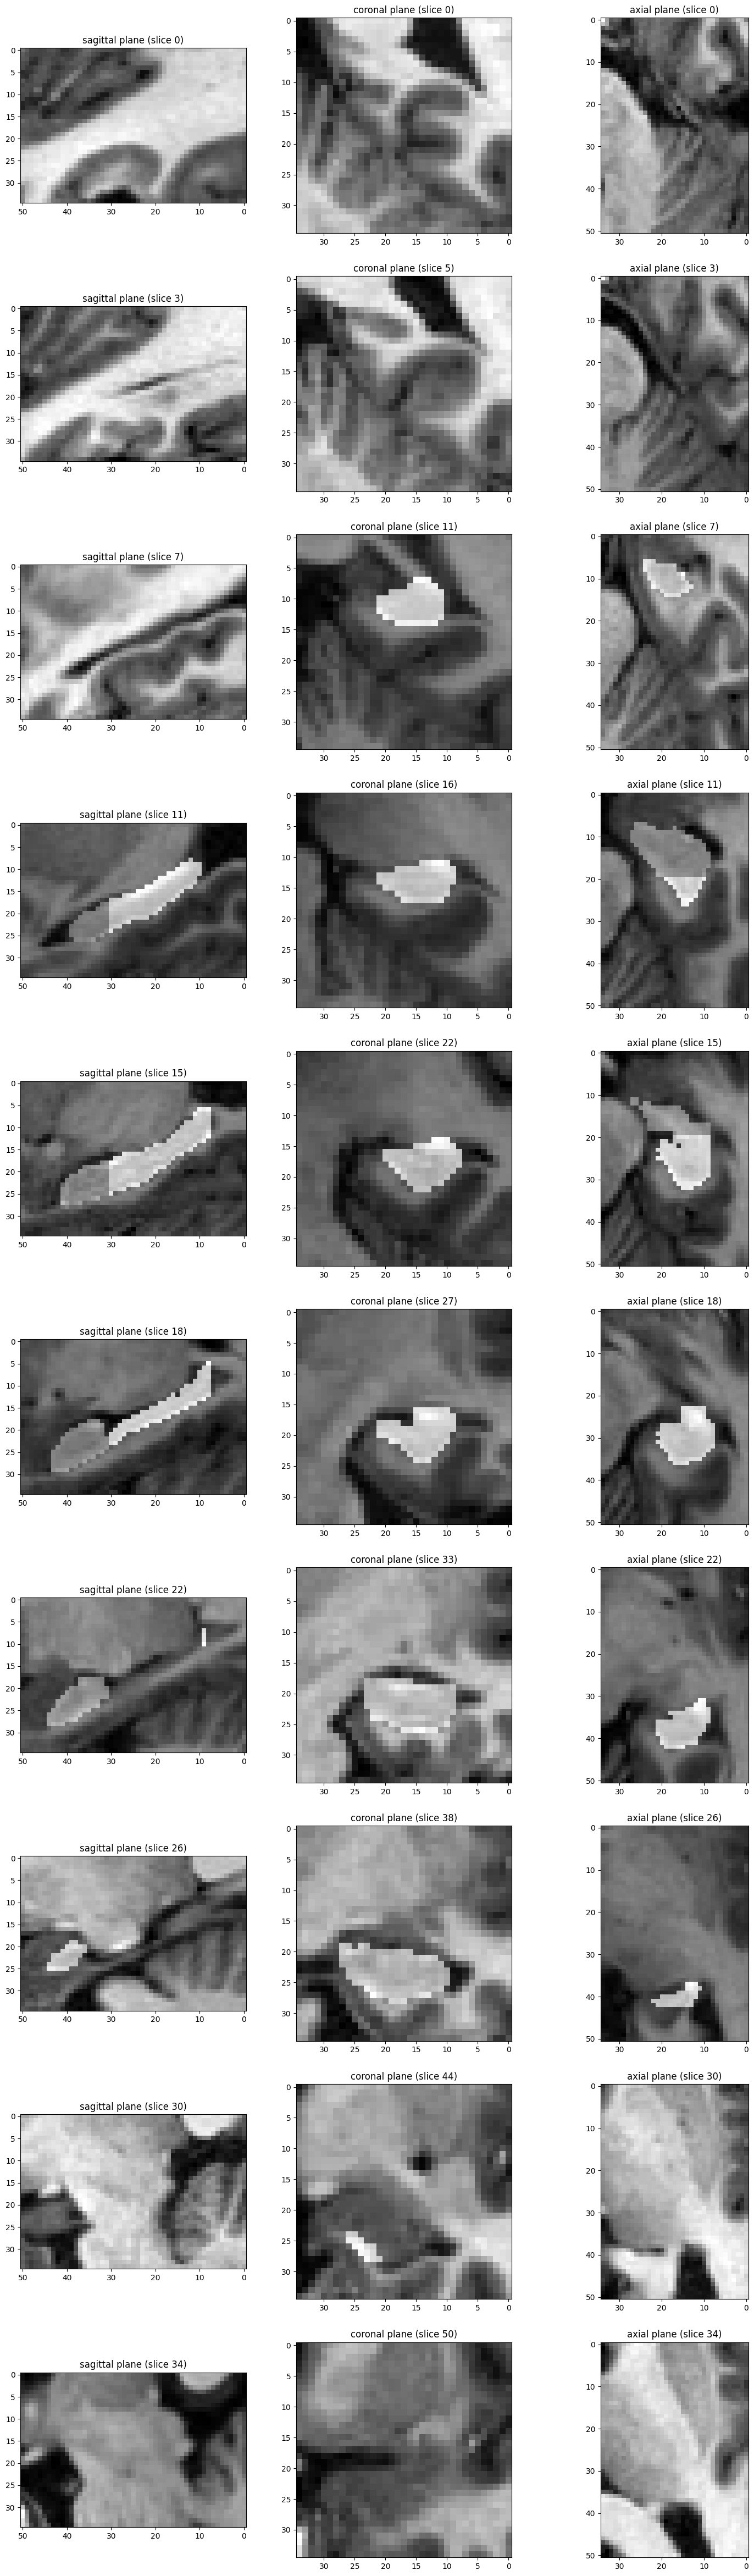

In [ ]:
intensity_factor = 50

## select how many slices in each cardinal plane to plot:
nr_slices = 10

range0 = np.linspace(0, img_np.shape[0]-1, nr_slices)
range1 = np.linspace(0, img_np.shape[1]-1, nr_slices)
range2 = np.linspace(0, img_np.shape[2]-1, nr_slices)
fig, axarr = plt.subplots(nr_slices, 3, figsize=(3*6, 6*nr_slices))
for i in range(nr_slices):
    # plot a slice in sagittal plane with overlayed label mask:
    slice_nr0 = int(range0[i])
    axarr[i, 0].imshow(np.rot90(img_np[slice_nr0, :, :]) + np.rot90(label_np[slice_nr0, :, :])*intensity_factor, cmap='gray')
    ttl = f'sagittal plane (slice {slice_nr0})'
    axarr[i, 0].set_title(ttl)
    axarr[i, 0].invert_xaxis()

    slice_nr1 = int(range1[i])
    axarr[i, 1].imshow(np.rot90(img_np[:, slice_nr1, :]) + np.rot90(label_np[:, slice_nr1, :])*intensity_factor, cmap='gray')
    ttl = f'coronal plane (slice {slice_nr1})'
    axarr[i, 1].set_title(ttl)
    axarr[i, 1].invert_xaxis()

    slice_nr2 = int(range2[i])
    axarr[i, 2].imshow(np.rot90(img_np[:, :, slice_nr2]) + np.rot90(label_np[:, :, slice_nr2])*intensity_factor, cmap='gray')
    ttl = f'axial plane (slice {slice_nr2})'
    axarr[i, 2].set_title(ttl)
    axarr[i, 2].invert_xaxis()

In [ ]:
def load_samples(dataframe):
  samples=[]
  for index, row in df.iterrows():
    samples.append(row.to_list())
  return samples

In [ ]:
df_samples = load_samples(df)

# Split the dataframe

First let's split the train test and validation dataframes then we load each sample category by itself. <br>
The data is split into: <br>
* 70% training
* 15% testing
* 15% validation

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test= train_test_split(df, test_size=0.15, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.15, random_state=42)

In [ ]:
df_train.head()

,Image_Path,Label_Path
93,/content/drive/MyDrive/Datasets/Task04_Hippoca...,/content/drive/MyDrive/Datasets/Task04_Hippoca...
152,/content/drive/MyDrive/Datasets/Task04_Hippoca...,/content/drive/MyDrive/Datasets/Task04_Hippoca...
76,/content/drive/MyDrive/Datasets/Task04_Hippoca...,/content/drive/MyDrive/Datasets/Task04_Hippoca...
180,/content/drive/MyDrive/Datasets/Task04_Hippoca...,/content/drive/MyDrive/Datasets/Task04_Hippoca...
53,/content/drive/MyDrive/Datasets/Task04_Hippoca...,/content/drive/MyDrive/Datasets/Task04_Hippoca...


In [ ]:
df_train.shape

(187, 2)

In [ ]:
df_test.head()

,Image_Path,Label_Path
30,/content/drive/MyDrive/Datasets/Task04_Hippoca...,/content/drive/MyDrive/Datasets/Task04_Hippoca...
181,/content/drive/MyDrive/Datasets/Task04_Hippoca...,/content/drive/MyDrive/Datasets/Task04_Hippoca...
223,/content/drive/MyDrive/Datasets/Task04_Hippoca...,/content/drive/MyDrive/Datasets/Task04_Hippoca...
185,/content/drive/MyDrive/Datasets/Task04_Hippoca...,/content/drive/MyDrive/Datasets/Task04_Hippoca...
211,/content/drive/MyDrive/Datasets/Task04_Hippoca...,/content/drive/MyDrive/Datasets/Task04_Hippoca...


In [ ]:
df_test.shape

(39, 2)

In [ ]:
df_val.head()

,Image_Path,Label_Path
47,/content/drive/MyDrive/Datasets/Task04_Hippoca...,/content/drive/MyDrive/Datasets/Task04_Hippoca...
80,/content/drive/MyDrive/Datasets/Task04_Hippoca...,/content/drive/MyDrive/Datasets/Task04_Hippoca...
100,/content/drive/MyDrive/Datasets/Task04_Hippoca...,/content/drive/MyDrive/Datasets/Task04_Hippoca...
14,/content/drive/MyDrive/Datasets/Task04_Hippoca...,/content/drive/MyDrive/Datasets/Task04_Hippoca...
16,/content/drive/MyDrive/Datasets/Task04_Hippoca...,/content/drive/MyDrive/Datasets/Task04_Hippoca...


In [ ]:
df_val.shape

(34, 2)

In [ ]:
train_samples = load_samples(df_train)
test_samples = load_samples(df_test)
val_samples = load_samples(df_val)

In [ ]:
train_samples[0]

['/content/drive/MyDrive/Datasets/Task04_Hippocampus/imagesTr/hippocampus_001.nii',
 '/content/drive/MyDrive/Datasets/Task04_Hippocampus/labelsTr/hippocampus_001.nii']

In [ ]:
test_samples[7]

['/content/drive/MyDrive/Datasets/Task04_Hippocampus/imagesTr/hippocampus_014.nii',
 '/content/drive/MyDrive/Datasets/Task04_Hippocampus/labelsTr/hippocampus_014.nii']

In [ ]:
val_samples[16]

['/content/drive/MyDrive/Datasets/Task04_Hippocampus/imagesTr/hippocampus_033.nii',
 '/content/drive/MyDrive/Datasets/Task04_Hippocampus/labelsTr/hippocampus_033.nii']

# Building and training the model: UNet 2D

## 1. Defining the metrics

* The Dice coefficient ranges from 0 to 1, where 0 indicates no overlap between the predicted and ground truth segmentations, and 1 indicates perfect overlap.
* IoU also ranges from 0 to 1, with 0 indicating no overlap and 1 indicating perfect overlap.
* BCE Loss measures the dissimilarity between the predicted probability distribution and the ground truth distribution

In [ ]:
smooth=1
def dice_coef(y_true, y_pred):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

## 2. Building the model

[Unet 2D](https://lukmanaj.medium.com/u-net-architecture-revolutionizing-computer-vision-through-innovative-image-segmentation-e1e2155c38b1)



In [ ]:
def create_unet_model(input_shape):
  inputs = Input(input_shape)

  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
  c1 = tf.keras.layers.Dropout(0.1)(c1)
  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = tf.keras.layers.Dropout(0.1)(c2)
  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

  c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = tf.keras.layers.Dropout(0.2)(c3)
  c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

  c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = tf.keras.layers.Dropout(0.2)(c4)
  c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

  c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = tf.keras.layers.Dropout(0.3)(c5)
  c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  #Decoder path
  u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = tf.keras.layers.Dropout(0.2)(c6)
  c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

  u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = tf.keras.layers.Dropout(0.2)(c7)
  c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

  u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = tf.keras.layers.Dropout(0.1)(c8)
  c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

  u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = tf.keras.layers.Dropout(0.1)(c9)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

  model.compile(optimizer=Adam(learning_rate=1e-4), loss=bce_dice_loss, metrics=[iou, dice_coef])

  return model

## 3. Preprocessing tasks

We take twenty slices from each image and each label  and append them into a list

In [ ]:
def load_nifti_data_2D(path):
    images = []
    image_data = nib.load(path).get_fdata()

    for img_slice in range(20):
        current_slice = image_data[:, :, img_slice]
        images.append(current_slice)

    return images

In [ ]:
def images_preprocessing(img):
  img = cv2.resize(img, (128,128))
  img = img/255.0

In [ ]:
def preprocessing(path):
  list_img = load_nifti_data_2D(path)
  for element in list_img:
    images_preprocessing(element)
  return list_img

In [ ]:
element = val_samples[5]

In [ ]:
l_m = preprocessing(element[0])

In [ ]:
type(l_m[0])

numpy.ndarray

In [ ]:
l_m[0].shape

(36, 48)

## 4. Data Augmentation

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, samples, batch_size=32, shuffle=True, augmentation=True):
        self.samples = samples
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.indexes = np.arange(len(self.samples))
        self.on_epoch_end()

        # ImageDataGenerator for data augmentation
        self.data_generator = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.2,
            fill_mode='nearest'
        )

    def __len__(self):
        return int(np.ceil(len(self.samples) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_samples = self.samples[start:end]

        X, y = self.__data_generation(batch_samples)

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_samples):
        X = []
        y = []

        for sample in batch_samples:
            images = preprocessing(sample[0])
            labels = preprocessing(sample[1])

            for img, lb in zip(images, labels):
                img = cv2.resize(img, (128, 128))
                lb = cv2.resize(lb, (128, 128))

                if self.augmentation:
                    # Apply data augmentation
                    img, lb = self.apply_augmentation(img, lb)

                X.append(img)
                y.append(lb)

        return np.array(X), np.array(y)

    def apply_augmentation(self, image, label):
      image = np.reshape(image, (128, 128, 1))
      label = np.reshape(label, (128, 128, 1))
      augmented_data = np.concatenate([image, label], axis=-1)
      augmented_data = self.data_generator.random_transform(augmented_data)
      augmented_image = augmented_data[:, :, 0]
      augmented_label = augmented_data[:, :, 1]

      return augmented_image, augmented_label


batch_size = 16
train_generator = DataGenerator(train_samples, batch_size=batch_size)
val_generator = DataGenerator(val_samples, batch_size=batch_size)


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, samples, batch_size=32, shuffle=True):
        self.samples = samples
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.samples))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.samples) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_samples = self.samples[start:end]

        X, y = self.__data_generation(batch_samples)

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_samples):
        X = []
        y = []

        for sample in batch_samples:
            images = preprocessing(sample[0])
            labels = preprocessing(sample[1])

            for img, lb in zip(images, labels):
                img = cv2.resize(img, (128, 128))
                lb = cv2.resize(lb, (128, 128))

                X.append(img)
                y.append(lb)

        return np.array(X), np.array(y)

# Create data generators
batch_size = 16
train_generator = DataGenerator(train_samples, batch_size=batch_size)
val_generator = DataGenerator(val_samples, batch_size=batch_size)

In [ ]:
epochs = 10
input_shape = (128, 128, 1)
model = create_unet_model(input_shape)
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/10
17/17 [==============================] - 97s 3s/step - loss: 1.7454 - iou: 0.0941 - dice_coef: 0.1720 - val_loss: 1.6699 - val_iou: 0.0778 - val_dice_coef: 0.1443
Epoch 2/10
17/17 [==============================] - 43s 3s/step - loss: 1.6403 - iou: 0.0708 - dice_coef: 0.1321 - val_loss: 1.6928 - val_iou: 0.0021 - val_dice_coef: 0.0043
Epoch 3/10
17/17 [==============================] - 43s 3s/step - loss: 1.5983 - iou: 0.0789 - dice_coef: 0.1462 - val_loss: 1.6913 - val_iou: 0.0030 - val_dice_coef: 0.0060
Epoch 4/10
17/17 [==============================] - 43s 3s/step - loss: 1.5779 - iou: 0.0893 - dice_coef: 0.1638 - val_loss: 1.6664 - val_iou: 0.0173 - val_dice_coef: 0.0340
Epoch 5/10
17/17 [==============================] - 43s 3s/step - loss: 1.5483 - iou: 0.1072 - dice_coef: 0.1935 - val_loss: 1.6816 - val_iou: 0.0089 - val_dice_coef: 0.0176
Epoch 6/10
17/17 [==============================] - 43s 3s/step - loss: 1.5413 - iou: 0.1209 - dice_coef: 0.2156 - val_loss: 1.620

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 128, 128, 16)         160       ['input_2[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 128, 128, 16)         0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 128, 128, 16)         2320      ['dropout_9[0][0]']           
                                                                                            

#Making prediction

In [ ]:
test_generator = DataGenerator(test_samples, batch_size=batch_size)
test_loss, test_iou, test_dice = model.evaluate(test_generator)

print(f'Test Loss: {test_loss}')
print(f'Test IoU: {test_iou}')
print(f'Test Dice Coefficient: {test_dice}')

num_samples_to_visualize = 5
random_test_samples = random.sample(test_samples, num_samples_to_visualize)

visualization_generator = DataGenerator(random_test_samples, batch_size=num_samples_to_visualize, shuffle=False)

predictions = model.predict(visualization_generator)



17/17 [==============================] - 19s 1s/step - loss: 1.4153 - iou: 0.1595 - dice_coef: 0.2751
Test Loss: 1.4152754545211792
Test IoU: 0.1595156341791153
Test Dice Coefficient: 0.27505412697792053
1/1 [==============================] - 1s 847ms/step


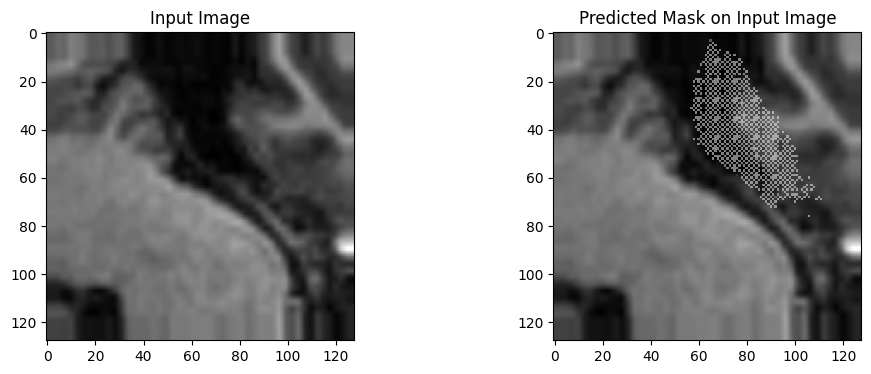

In [ ]:
if not visualization_generator:
    print("Empty generator. No samples to visualize.")
else:
    for i in range(min(num_samples_to_visualize, len(visualization_generator))):
        input_image = visualization_generator[i][0][0]  # Input image
        prediction = predictions[i]  # Predicted mask

        alpha = 0.5
        cmap = plt.cm.gray
        norm = plt.Normalize(0, 1)
        rgba = cmap(norm(prediction.squeeze()))
        rgba[:, :, 3] = alpha * prediction.squeeze()

        # Plot the figures
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(input_image.squeeze(), cmap='gray')
        plt.title('Input Image')

        plt.subplot(1, 2, 2)
        plt.imshow(input_image.squeeze(), cmap='gray')
        plt.imshow(rgba, cmap='gray', interpolation='none')  # Overlay predicted mask
        plt.title('Predicted Mask on Input Image')

        plt.show()
